# Clustering Iris

In [44]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

# Path to your audio directory
fragmenten_df = pd.read_csv('Data/fragments_data.csv')

train_data, test_data = train_test_split(fragmenten_df, test_size=0.3, random_state=42)
print(test_data['labels'].value_counts())

labels
tureluur                  362
oeverloper                256
witgat                    202
watersnip                 170
zwarte ruiter             149
geelpootruiter             11
grauwe franjepoot          10
steenloper                  7
steltloper                  3
amerikaanse oeverloper      1
Name: count, dtype: int64


In [45]:
# Setup lists
spectro_features = []
file_names = []
labels = []

for idx, row in test_data.iterrows():
    file_path = os.path.join("audio_fragments", row['fragment'])

    try:
        y, sr = librosa.load(file_path, sr=None)

        # Compute spectrogram (STFT)
        D = librosa.stft(y, n_fft=1024, hop_length=512)
        S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

        # Take mean energy per frequency bin (over time axis)
        spec_mean = np.mean(S_db, axis=1)

        spectro_features.append(spec_mean)
        file_names.append(row['fragment'])
        labels.append(row['labels'])

    except Exception as e:
        print(f"Fout bij laden van {row['fragment']}: {e}")

c:\Users\11897\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=369
  warnings.warn(
c:\Users\11897\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=645
  warnings.warn(
c:\Users\11897\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=974
  warnings.warn(
c:\Users\11897\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=360
  warnings.warn(


In [46]:
max_len = max([len(f) for f in spectro_features])
spectro_features = [np.pad(f, (0, max_len - len(f)), mode='constant') for f in spectro_features]

# Make a DataFrame
feature_df = pd.DataFrame(spectro_features)
feature_df['fragment'] = file_names
feature_df['label'] = labels

print(feature_df.columns)

Index([         0,          1,          2,          3,          4,          5,
                6,          7,          8,          9,
       ...
              505,        506,        507,        508,        509,        510,
              511,        512, 'fragment',    'label'],
      dtype='object', length=515)


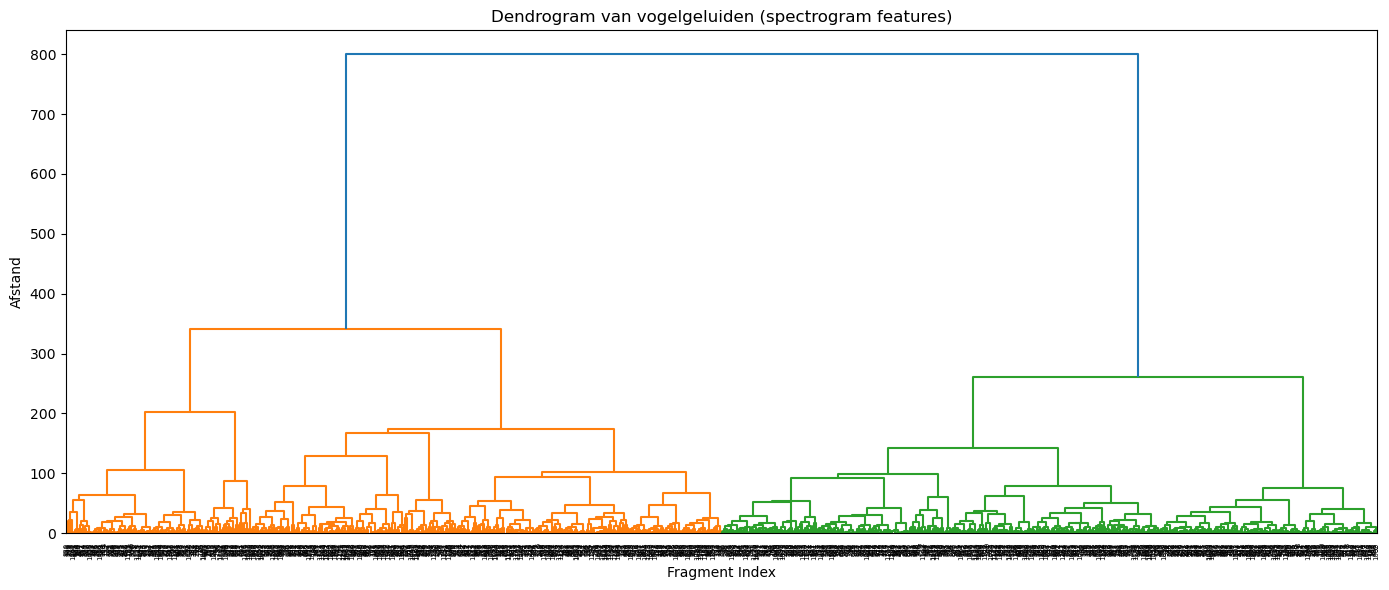

In [47]:
# Drop non-feature columns
X = feature_df.drop(columns=['fragment', 'label'])

# Schalen
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Linkage & dendrogram
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(14, 6))
dendrogram(linked, distance_sort='descending', show_leaf_counts=False)
plt.title("Dendrogram van vogelgeluiden (spectrogram features)")
plt.xlabel("Fragment Index")
plt.ylabel("Afstand")
plt.tight_layout()
plt.show()

# Agglomerative clustering
n_clusters = 10  # kies op basis van dendrogram
agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
feature_df['cluster'] = agglo.fit_predict(X_scaled)


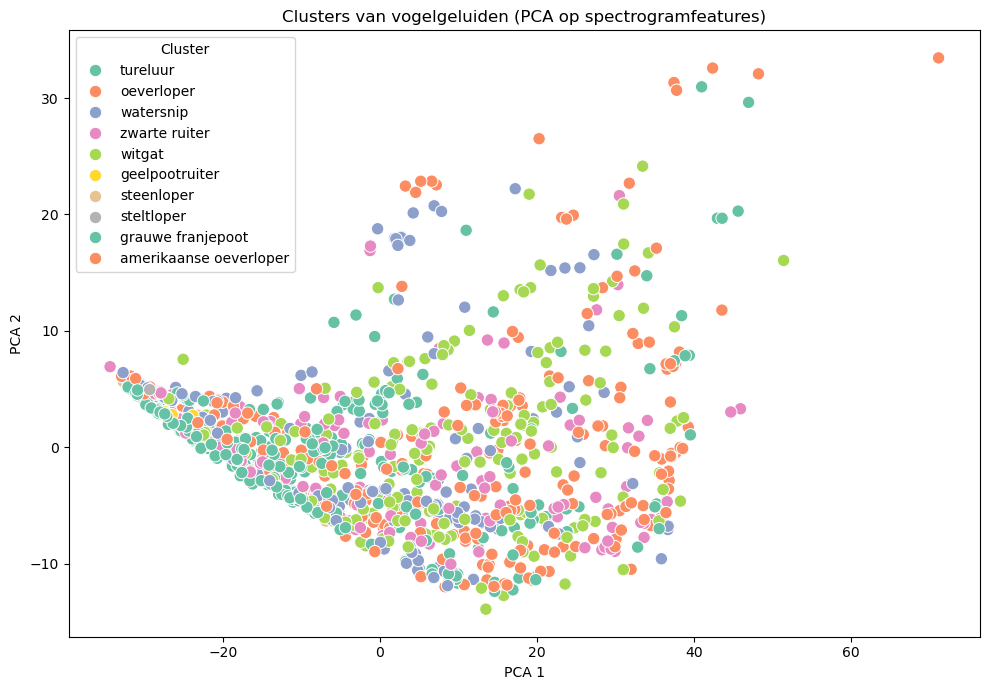

In [48]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                hue=feature_df['label'], palette='Set2', s=80)
plt.title("Clusters van vogelgeluiden (PCA op spectrogramfeatures)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


# Conclusie

Hieruit blijkt dat de agglomerative hierarchy clustering niet goed werkt voor onze casus, gezien de clusters niet goed genoeg gescheiden zijn van elkaar. Bij deze is alleen de spectrogram gebruikt wat niet voor duidelijke resultaten zorgt.

In [49]:
combined_features = []
file_names = []
labels = []

for idx, row in test_data.iterrows():
    file_path = os.path.join("audio_fragments", row['fragment'])

    try:
        y, sr = librosa.load(file_path, sr=None)

        # --- MFCC ---
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)

        # --- Spectrogram ---
        D = librosa.stft(y, n_fft=1024, hop_length=512)
        S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
        spec_mean = np.mean(S_db, axis=1)
        spec_mean = spec_mean[:50]  # Truncate for consistency (optional)

        # --- Chroma ---
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)

        # --- Spectral features ---
        centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        flatness = np.mean(librosa.feature.spectral_flatness(y=y))

        # --- Zero Crossing Rate ---
        zcr = np.mean(librosa.feature.zero_crossing_rate(y))

        # Combine everything
        features = np.concatenate([
            mfcc_mean,
            spec_mean,
            chroma_mean,
            [centroid, bandwidth, rolloff, flatness, zcr]
        ])

        combined_features.append(features)
        file_names.append(row['fragment'])
        labels.append(row['labels'])

    except Exception as e:
        print(f"Fout bij laden van {row['fragment']}: {e}")


c:\Users\11897\anaconda3\Lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
c:\Users\11897\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1083
  warnings.warn(
c:\Users\11897\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=369
  warnings.warn(
c:\Users\11897\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=369
  warnings.warn(
c:\Users\11897\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=645
  warnings.warn(
c:\Users\11897\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=645
  warnings.warn(
c:\Users\11897\anaconda3\Lib\site-packages\librosa\

In [50]:
max_len_combi = max([len(f) for f in combined_features])
spectro_features_combi = [np.pad(f, (0, max_len_combi - len(f)), mode='constant') for f in combined_features]

# Make a DataFrame
feature_df = pd.DataFrame(spectro_features_combi)
feature_df['fragment'] = file_names
feature_df['label'] = labels

print(feature_df.columns)

Index([         0,          1,          2,          3,          4,          5,
                6,          7,          8,          9,         10,         11,
               12,         13,         14,         15,         16,         17,
               18,         19,         20,         21,         22,         23,
               24,         25,         26,         27,         28,         29,
               30,         31,         32,         33,         34,         35,
               36,         37,         38,         39,         40,         41,
               42,         43,         44,         45,         46,         47,
               48,         49,         50,         51,         52,         53,
               54,         55,         56,         57,         58,         59,
               60,         61,         62,         63,         64,         65,
               66,         67,         68,         69,         70,         71,
               72,         73,         74,         7

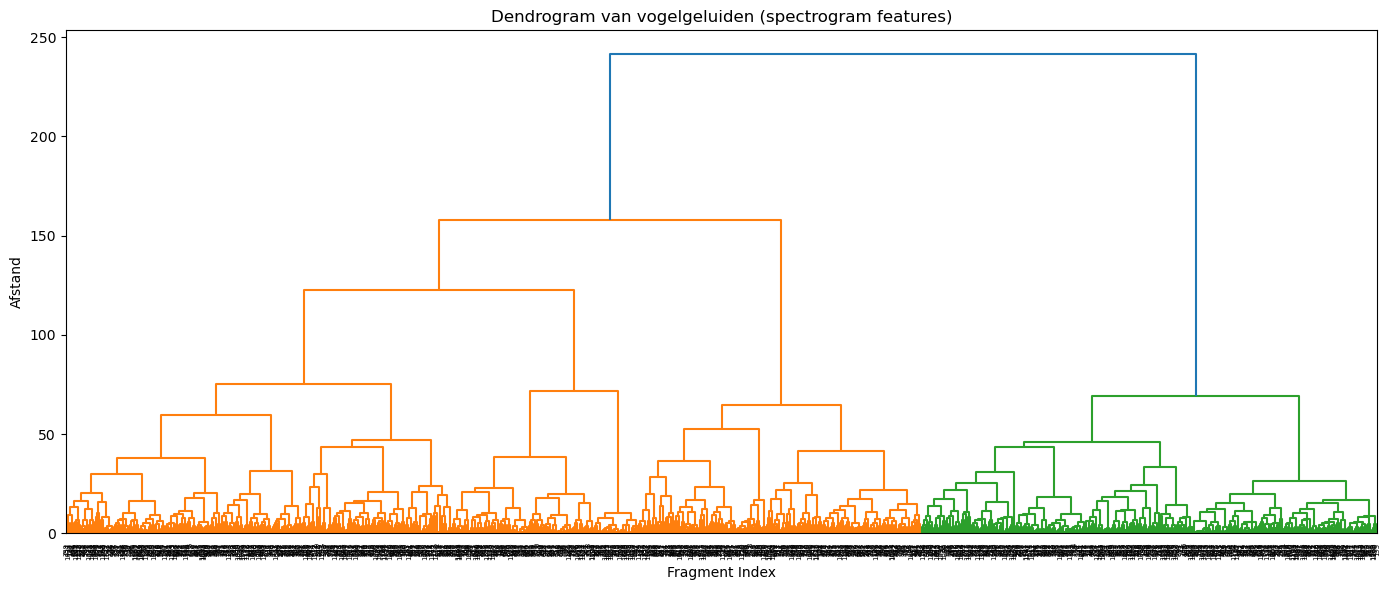

In [51]:
# Drop non-feature columns
X = feature_df.drop(columns=['fragment', 'label'])

# Schalen
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Linkage & dendrogram
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(14, 6))
dendrogram(linked, distance_sort='descending', show_leaf_counts=False)
plt.title("Dendrogram van vogelgeluiden (spectrogram features)")
plt.xlabel("Fragment Index")
plt.ylabel("Afstand")
plt.tight_layout()
plt.show()

# Agglomerative clustering
n_clusters = 10  # kies op basis van dendrogram
agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
feature_df['cluster'] = agglo.fit_predict(X_scaled)


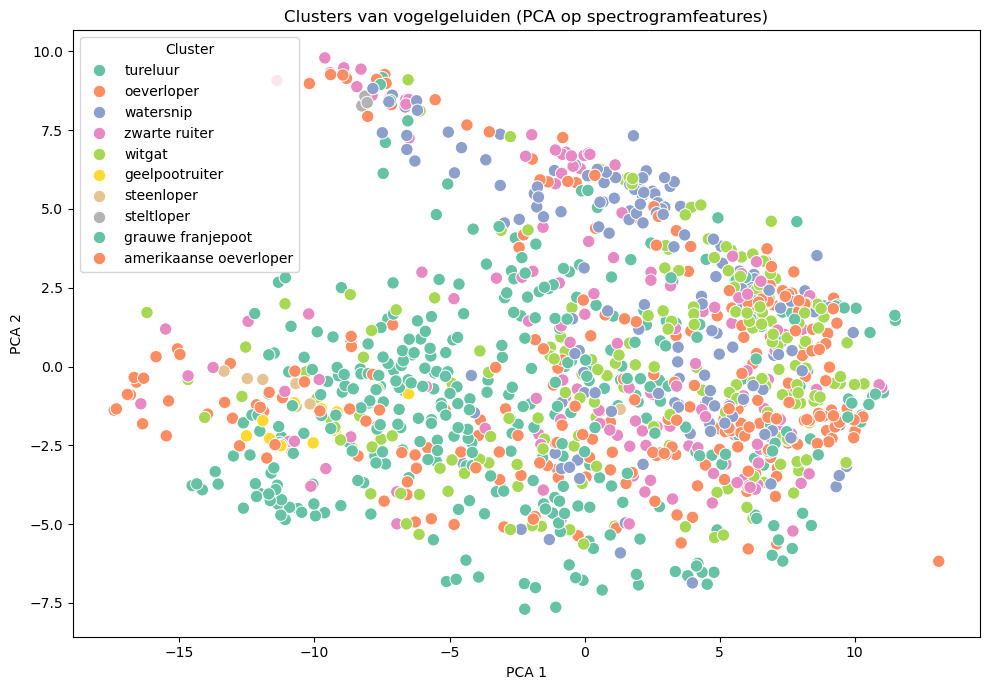

In [52]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                hue=feature_df['label'], palette='Set2', s=80)
plt.title("Clusters van vogelgeluiden (PCA op spectrogramfeatures)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


# Conclusie

Hieruit blijkt dat de agglomerative hierarchy clustering niet goed werkt voor onze casus, gezien de clusters niet goed genoeg gescheiden zijn van elkaar. Hier zijn een hele hoop feature-extractie methodes gebruikt, maar ook hier komen geen duidelijke resultaten uit.

In [53]:
mfcc_features = []
file_names = []
labels = []

for idx, row in test_data.iterrows():
    file_path = os.path.join("audio_fragments", row['fragment'])
    
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)  # Average over time

        mfcc_features.append(mfcc_mean)
        file_names.append(row['fragment'])
        labels.append(row['labels'])
    
    except Exception as e:
        print(f"Fout bij laden van {row['fragment']}: {e}")


feature_df = pd.DataFrame(mfcc_features)
feature_df['fragment'] = file_names
feature_df['label'] = labels

print(feature_df.columns)

c:\Users\11897\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1083
  warnings.warn(
c:\Users\11897\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=369
  warnings.warn(
c:\Users\11897\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=645
  warnings.warn(
c:\Users\11897\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=974
  warnings.warn(
c:\Users\11897\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1527
  warnings.warn(
c:\Users\11897\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=360
  warnings.warn(


Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 'fragment', 'label'], dtype='object')


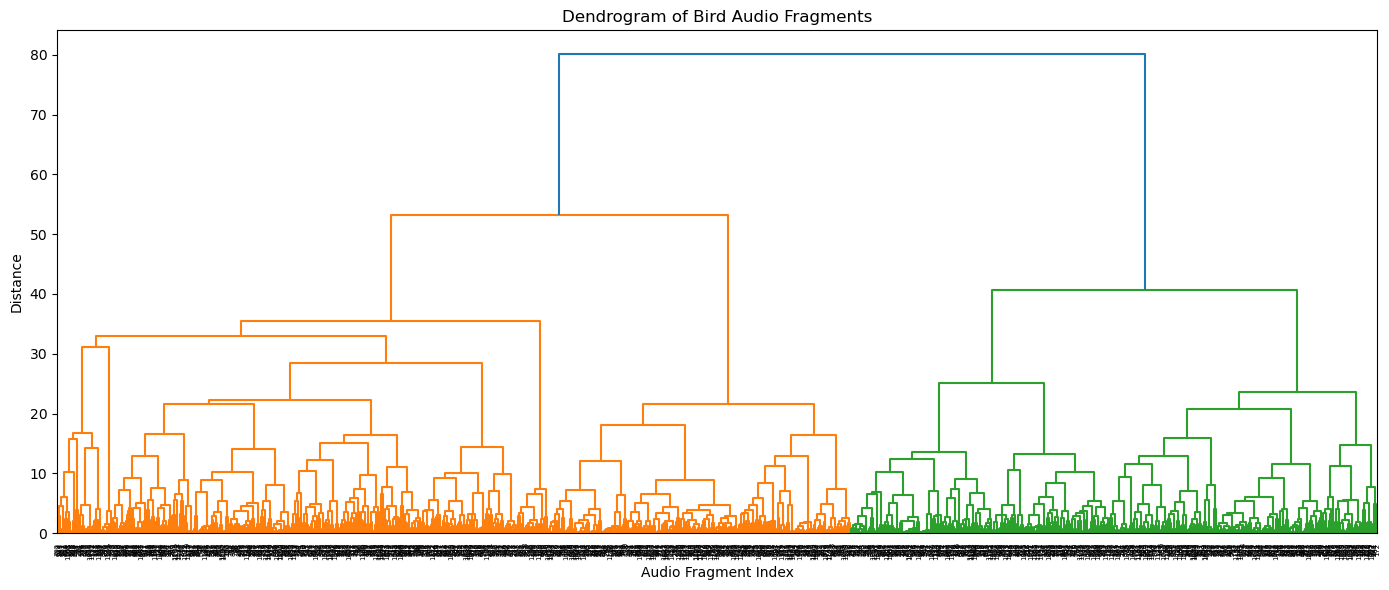

In [54]:
# Prepare data for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(feature_df.drop(columns=['fragment', 'label']))

# Linkage for dendrogram
linked = linkage(X_scaled, method='ward')

# Dendrogram
plt.figure(figsize=(14, 6))
dendrogram(linked, distance_sort='descending', show_leaf_counts=False)
plt.title("Dendrogram of Bird Audio Fragments")
plt.xlabel("Audio Fragment Index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


In [55]:
n_clusters = 10

agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
cluster_labels = agglo.fit_predict(X_scaled)

print(feature_df.columns)

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 'fragment', 'label'], dtype='object')


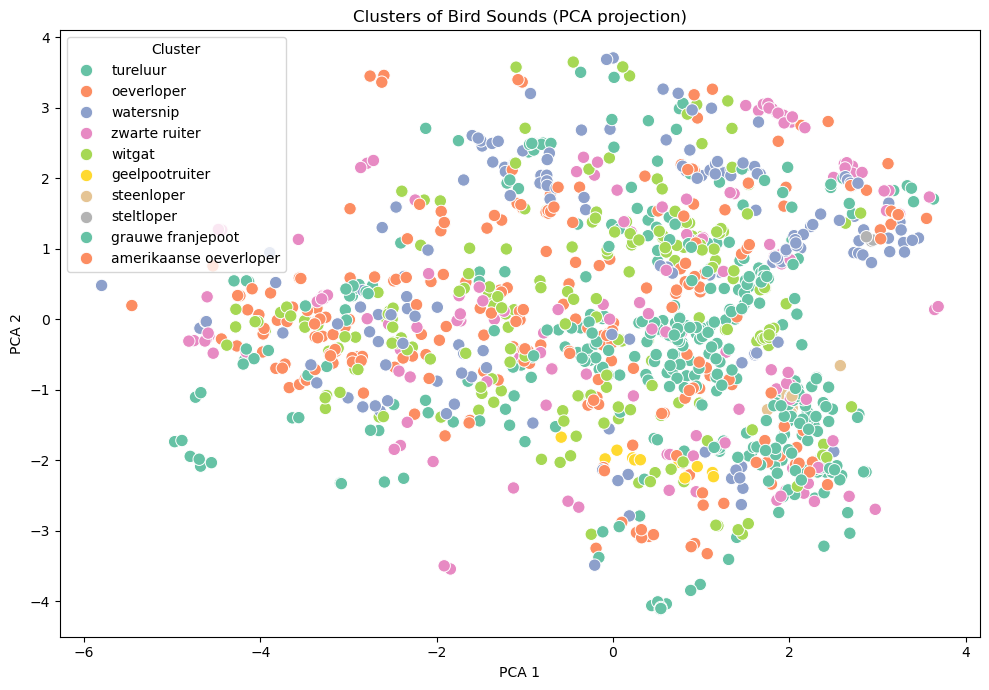

In [56]:
# Add cluster labels to the dataframe
feature_df['cluster'] = cluster_labels

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                hue=feature_df['label'], palette='Set2', s=80)
plt.title("Clusters of Bird Sounds (PCA projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


# Conclusie
Hierbij is alleen de MFCC toegepast, ook hier komen geen duidelijke resultaten uit